In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *
from coronita_web_helper import *
from coronita_bokeh_helper import *



In [2]:
def footnote_str_maker():
    footnote_str = 'www.COVIDoutlook.info | twtr: @COVIDoutlook\nChart created on {}'.format(
        pd.Timestamp.today().strftime("%d %b, %Y at %I:%M %p"))
    return footnote_str

In [3]:
df_nyc_tests_raw = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/tests.csv')
df_nyc_tests_raw.tail(8)

,DATE,TOTAL_TESTS,POSITIVE_TESTS,PERCENT_POSITIVE,TOTAL_TESTS_7DAYS_AVG,POSITIVE_TESTS_7DAYS_AVG,PERCENT_POSITIVE_7DAYS_AVG,INCOMPLETE
206,09/25/2020,33979,535,0.0157,31859.0,457.0,0.014,NaN
207,09/26/2020,17194,301,0.0175,32140.0,472.0,0.015,45000.0
208,09/27/2020,13336,428,0.0321,32278.0,505.0,0.016,45000.0
209,09/28/2020,42260,516,0.0122,32267.0,489.0,0.015,45000.0
210,09/29/2020,40243,766,0.0190,32514.0,530.0,0.016,45000.0
211,09/30/2020,36675,653,0.0178,31672.0,537.0,0.017,45000.0
212,10/01/2020,30157,545,0.0181,30549.0,535.0,0.018,45000.0
213,10/02/2020,23407,339,0.0145,29039.0,507.0,0.017,45000.0


In [4]:
df_nyc_tests_raw_0923 = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/1d5d6a1a95a78a863630c748e2aff251eed2ca95/tests.csv')
df_nyc_tests_raw_0923.tail()


,DATE,TOTAL_TESTS,POSITIVE_TESTS,PERCENT_POSITIVE,TOTAL_TESTS_7DAYS_AVG,POSITIVE_TESTS_7DAYS_AVG,INCOMPLETE
197,09/16/2020,38887,448,0.0115,32043.0,387.0,45000.0
198,09/17/2020,36078,414,0.0115,31739.0,389.0,45000.0
199,09/18/2020,28973,320,0.0110,30855.0,379.0,45000.0
200,09/19/2020,12519,143,0.0114,30257.0,365.0,45000.0
201,09/20/2020,7434,107,0.0144,29268.0,335.0,45000.0


In [5]:
df_nyc_tests = df_nyc_tests_raw.copy()
df_nyc_tests['DATE'] = pd.to_datetime(df_nyc_tests['DATE'])
df_nyc_tests = df_nyc_tests.set_index('DATE')
df_nyc_tests.head()


,TOTAL_TESTS,POSITIVE_TESTS,PERCENT_POSITIVE,TOTAL_TESTS_7DAYS_AVG,POSITIVE_TESTS_7DAYS_AVG,PERCENT_POSITIVE_7DAYS_AVG,INCOMPLETE
DATE,,,,,,,
2020-03-03,14,1,0.0714,NaN,NaN,NaN,NaN
2020-03-04,33,5,0.1515,NaN,NaN,NaN,NaN
2020-03-05,65,4,0.0615,NaN,NaN,NaN,NaN
2020-03-06,85,8,0.0941,NaN,NaN,NaN,NaN
2020-03-07,72,8,0.1111,NaN,NaN,NaN,NaN


`axes.prop_cycle: cycler('color', ['E24A33', '348ABD', '988ED5', '777777', 'FBC15E', '8EBA42', 'FFB5B8'])
                   # E24A33 : red
                   # 348ABD : blue
                   # 988ED5 : purple
                   # 777777 : gray
                   # FBC15E : yellow
                   # 8EBA42 : green
                   # FFB5B8 : pink`

,x,y
0,2020-09-28,10400


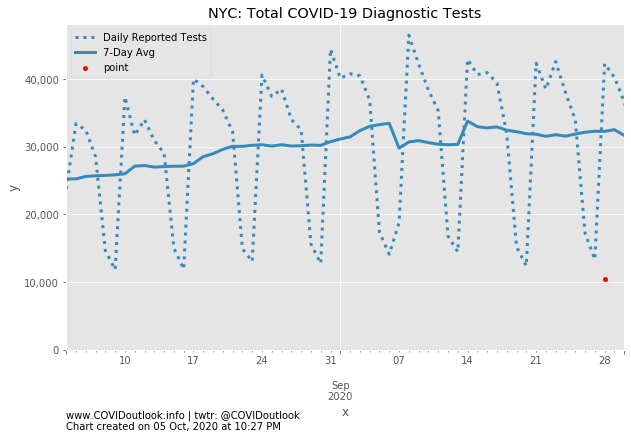

In [6]:
thismetric = 'TOTAL_TESTS'
thistitle = 'NYC: Total COVID-19 Diagnostic Tests'
thiscolor = '#348ABD'
this_series = df_nyc_tests[thismetric].iloc[-60:]
this_rolling_series = df_nyc_tests[thismetric].rolling(7).mean().iloc[-60:]

ax = this_series.plot(
    title=thistitle,
    label='Daily Reported Tests', legend=True, 
    linestyle=':', linewidth=3, color=thiscolor)
this_rolling_series.plot(
    ax=ax, label='7-Day Avg', legend=True, figsize=[10,6], 
    linewidth=3, color=thiscolor)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xlim([ax.get_xlim()[0],pd.Timestamp('2020-09-30') ])
ax.set_xlabel('')
plt.annotate(footnote_str_maker(),
                 (0, 0), (0, -60), xycoords='axes fraction', textcoords='offset points', va='top')

point=pd.DataFrame(
                  {'x': [pd.Timestamp('2020-09-28')], 'y': [10400]})
point.plot(x='x',y='y', ax=ax, kind='scatter', label='point', color='red')
point


Text(0, -60, 'www.COVIDoutlook.info | twtr: @COVIDoutlook\nChart created on 05 Oct, 2020 at 10:27 PM')

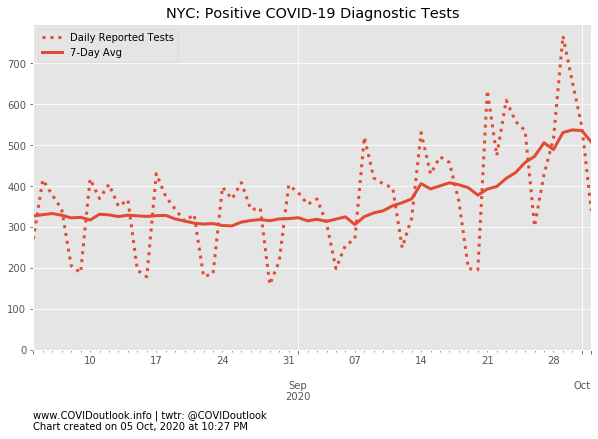

In [7]:
thismetric = 'POSITIVE_TESTS'
thistitle = 'NYC: Positive COVID-19 Diagnostic Tests'
thiscolor = '#E24A33'
this_series = df_nyc_tests[thismetric].iloc[-60:]
this_rolling_series = df_nyc_tests[thismetric].rolling(7).mean().iloc[-60:]

ax = this_series.plot(
    title=thistitle,
    label='Daily Reported Tests', legend=True, 
    linestyle=':', linewidth=3, color=thiscolor)
this_rolling_series.plot(
    ax=ax, label='7-Day Avg', legend=True, figsize=[10,6], 
    linewidth=3, color=thiscolor)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xlabel('')
plt.annotate(footnote_str_maker(),
                 (0, 0), (0, -60), xycoords='axes fraction', textcoords='offset points', va='top')



Text(0, -60, 'www.COVIDoutlook.info | twtr: @COVIDoutlook\nChart created on 05 Oct, 2020 at 10:27 PM')

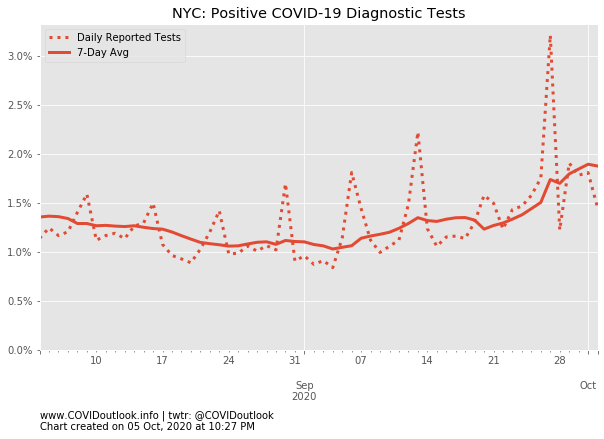

In [8]:
thistitle = 'NYC: Positive COVID-19 Diagnostic Tests'
thiscolor = '#E24A33'
this_series = (df_nyc_tests.POSITIVE_TESTS/df_nyc_tests.TOTAL_TESTS).iloc[-60:]
this_rolling_series = (df_nyc_tests.POSITIVE_TESTS/df_nyc_tests.TOTAL_TESTS).rolling(7).mean().iloc[-60:]

ax = this_series.plot(
    title=thistitle,
    label='Daily Reported Tests', legend=True, 
    linestyle=':', linewidth=3, color=thiscolor)
this_rolling_series.plot(
    ax=ax, label='7-Day Avg', legend=True, figsize=[10,6], 
    linewidth=3, color=thiscolor)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xlabel('')
plt.annotate(footnote_str_maker(),
                 (0, 0), (0, -60), xycoords='axes fraction', textcoords='offset points', va='top')




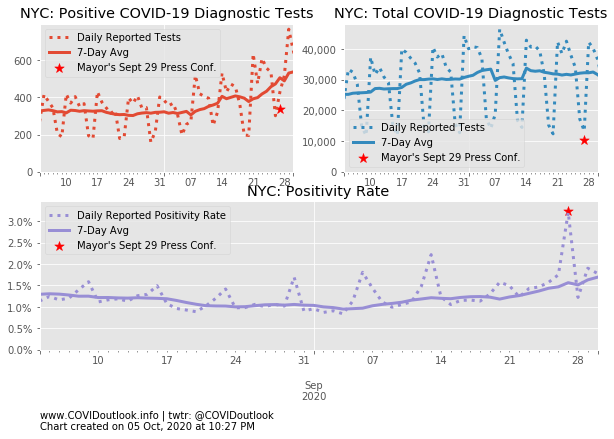

In [9]:
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

thismetric = 'POSITIVE_TESTS'
thistitle = 'NYC: Positive COVID-19 Diagnostic Tests'
thiscolor = '#E24A33'
this_series = df_nyc_tests[thismetric].iloc[-60:]
this_rolling_series = df_nyc_tests[thismetric].rolling(7).mean().iloc[-60:]

this_series.plot(ax=ax1,
    title=thistitle,
    label='Daily Reported Tests', legend=True, 
    linestyle=':', linewidth=3, color=thiscolor)
this_rolling_series.plot(
    ax=ax1, label='7-Day Avg', legend=True, figsize=[10,6], 
    linewidth=3, color=thiscolor)
point=pd.DataFrame({'x': [pd.Timestamp('2020-09-27')], 'y': [338]})
point.plot(x='x',y='y', ax=ax1, kind='scatter', label='Mayor\'s Sept 29 Press Conf.', color='red',
          marker='*', s=100)

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.set_ylim([0, ax1.get_ylim()[1]])
ax1.set_xlim([ax1.get_xlim()[0],pd.Timestamp('2020-09-30') ])
ax1.set_xlabel('')
ax1.set_ylabel('')

thismetric = 'TOTAL_TESTS'
thistitle = 'NYC: Total COVID-19 Diagnostic Tests'
thiscolor = '#348ABD'
this_series = df_nyc_tests[thismetric].iloc[-60:]
this_rolling_series = df_nyc_tests[thismetric].rolling(7).mean().iloc[-60:]

this_series.plot(ax=ax2,
    title=thistitle,
    label='Daily Reported Tests', legend=True, 
    linestyle=':', linewidth=3, color=thiscolor)
this_rolling_series.plot(
    ax=ax2, label='7-Day Avg', legend=True, figsize=[10,6], 
    linewidth=3, color=thiscolor)
point=pd.DataFrame({'x': [pd.Timestamp('2020-09-27')], 'y': [10400]})
point.plot(x='x',y='y', ax=ax2, kind='scatter', label='Mayor\'s Sept 29 Press Conf.', color='red',
          marker='*', s=100)

ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.set_xlim([ax2.get_xlim()[0],pd.Timestamp('2020-09-30') ])
ax2.set_xlabel('')
ax2.set_ylabel('')

thistitle = 'NYC: Positivity Rate'
thiscolor = '#988ED5'
this_series = (df_nyc_tests.POSITIVE_TESTS/df_nyc_tests.TOTAL_TESTS).iloc[-60:]
# this_rolling_series = (df_nyc_tests.POSITIVE_TESTS/df_nyc_tests.TOTAL_TESTS).rolling(7).mean().iloc[-60:]
this_rolling_series = (df_nyc_tests.POSITIVE_TESTS.rolling(7).sum()
                       /df_nyc_tests.TOTAL_TESTS.rolling(7).sum()).iloc[-60:]

this_series.plot(ax=ax3,
    title=thistitle,
    label='Daily Reported Positivity Rate', legend=True, 
    linestyle=':', linewidth=3, color=thiscolor)
this_rolling_series.plot(
    ax=ax3, label='7-Day Avg', legend=True, figsize=[10,6], 
    linewidth=3, color=thiscolor)
point=pd.DataFrame({'x': [pd.Timestamp('2020-09-27')], 'y': [.0325]})
point.plot(x='x',y='y', ax=ax3, kind='scatter', label='Mayor\'s Sept 29 Press Conf.', color='red',
          marker='*', s=100)
ax3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
ax3.set_ylim([0, ax3.get_ylim()[1]])
ax3.set_xlim([ax3.get_xlim()[0],pd.Timestamp('2020-09-30') ])
ax3.set_xlabel('')
ax3.set_ylabel('')
plt.annotate(footnote_str_maker(),
                 (0, 0), (0, -60), xycoords='axes fraction', textcoords='offset points', va='top')


plt.show()


In [10]:
df_nyc_tests.POSITIVE_TESTS.iloc[-10:]

DATE
2020-09-23    609
2020-09-24    557
2020-09-25    535
2020-09-26    301
2020-09-27    428
2020-09-28    516
2020-09-29    766
2020-09-30    653
2020-10-01    545
2020-10-02    339
Name: POSITIVE_TESTS, dtype: int64

In [11]:
107/193

0.5544041450777202

In [12]:
7434/12167

0.610996958987425

In [13]:
df_nyc_tests.TOTAL_TESTS.tail(14)

DATE
2020-09-19    15224
2020-09-20    12374
2020-09-21    42337
2020-09-22    38514
2020-09-23    42566
2020-09-24    38019
2020-09-25    33979
2020-09-26    17194
2020-09-27    13336
2020-09-28    42260
2020-09-29    40243
2020-09-30    36675
2020-10-01    30157
2020-10-02    23407
Name: TOTAL_TESTS, dtype: int64

In [14]:
df_positivity = (df_nyc_tests.POSITIVE_TESTS/df_nyc_tests.TOTAL_TESTS).iloc[-64:-1].reset_index()
df_positivity['dow'] = df_positivity.DATE.dt.dayofweek.astype(str)+': '+df_positivity.DATE.dt.day_name()
df_positivity['week'] = df_positivity.DATE.dt.week
df_chart = df_positivity.pivot(index='dow',columns='week', values=0)
df_chart.mean(axis=1)

dow
0: Monday       0.011935
1: Tuesday      0.011679
2: Wednesday    0.011824
3: Thursday     0.011763
4: Friday       0.011725
5: Saturday     0.013718
6: Sunday       0.018442
dtype: float64

In [15]:
df_chart.mean(axis=1).loc['6: Sunday']/df_chart.mean(axis=1).iloc[:5].mean()

1.5648858277181907

Text(0, -80, 'www.COVIDoutlook.info | twtr: @COVIDoutlook\nChart created on 05 Oct, 2020 at 10:27 PM')

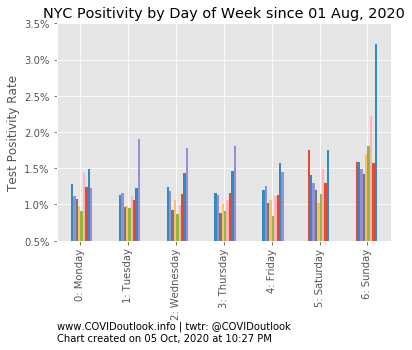

In [16]:
df_positivity = (df_nyc_tests.POSITIVE_TESTS/df_nyc_tests.TOTAL_TESTS).iloc[-63:].reset_index()
first_dt = df_positivity.DATE.min().strftime("%d %b, %Y")
df_positivity['dow'] = df_positivity.DATE.dt.dayofweek.astype(str)+': '+df_positivity.DATE.dt.day_name()
df_positivity['week'] = df_positivity.DATE.dt.week
df_chart = df_positivity.pivot(index='dow',columns='week', values=0)
ax = df_chart.plot(kind='bar', legend=False,
                  title='NYC Positivity by Day of Week since '+first_dt)
ax.set_ylim([.005,.035])
ax.set_xlabel('')
ax.set_ylabel('Test Positivity Rate')
# df_positivity.set_index('dow').plot(kind='bar' )
df_positivity.tail()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
plt.annotate(footnote_str_maker(),
                 (0, 0), (0, -80), xycoords='axes fraction', textcoords='offset points', va='top')



In [17]:
df_nyc_tests.POSITIVE_TESTS.tail(14)

DATE
2020-09-19    198
2020-09-20    195
2020-09-21    633
2020-09-22    474
2020-09-23    609
2020-09-24    557
2020-09-25    535
2020-09-26    301
2020-09-27    428
2020-09-28    516
2020-09-29    766
2020-09-30    653
2020-10-01    545
2020-10-02    339
Name: POSITIVE_TESTS, dtype: int64